In [1]:
# importing useful libraries 
import matplotlib.pyplot as plt 
import scipy.stats as sp 
import pandas as pd 
import numpy as np 
from scipy.stats import norm

In [39]:
# parameters 
N = [10, 100, 500, 1000, 5000, 10000]
S0 = 100 
sigma = 0.2 
mu = 0.03 
r = 0.015 
K = 97 
T = 1 
M = 10000

In [53]:
# payoff formula 
def payoff(S, K): 
    return np.maximum(S[:,-1]-K, 0) 

# simulating the risky asset 
# returning a matrix of M simulations and N steps  
def S(S0, T, mu, sigma, N, M): 
    h = T/N 
    # simulation of N normal random variable realisations 
    Norm = np.random.normal(0,1,(M, N)) 
    S = np.zeros((M, N+1))
    S[:,0] = S0 
    # Si+1 <-- Si*exp(sigma*sqrt(h)Ni + (mu -sigma**2/2)*h)
    S[:,1:]= S0*np.cumprod(np.exp(sigma*np.sqrt(h)*Norm + (mu - (sigma**2/2))*h), axis=1)
    return S 

# The value of d1 in the black and scholes formula 
def d_1(S, K, r, T, sigma):
    return (1/(sigma*np.sqrt(T)))*(np.log(S/K) + (r + 0.5* sigma**2)*T)

# Call price at 0 
def call(K, S0, r, sigma, T):
    d1 = d_1(S0, K, r, T, sigma) 
    d2 = d1 - sigma*np.sqrt(T) 
    return S0*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2) 

# delta after deriving the Black and Scholes formula giving Ft with respect to St 
def delta_(S, K, r, T, sigma):
    d1 = d_1(S, K, r, T, sigma)
    return norm.cdf(d1)

# discrete replication strategie of the fair price at time ti (Portfolio)
def Vi_(K, S, r, sigma, T, N): 
    Vi = np.zeros(S.shape) 
    h = T/N 
    Vi[:, 0] = call(K, S[0,0], r, sigma, T)

    for i in range(1,N+1):
        ti = (i-1)*h 
        delta = delta_(S[:, i-1], K, r, T-ti, sigma)
        Vi[:, i] = Vi[:, i-1] + delta*(S[:, i]-S[:, i-1]) + (Vi[:, i-1]-delta*S[:, i-1])*(np.exp(r*h)-1)  
    return Vi 


# for an h determining the number of the value of M such as the standard deviation between 
# the discretised portfolio and the pay-off is a constant for a fixed h 
def std(K, S0, r, sigma, T, N, M, ax = None):
    
    h = T/N

    Si = S(S0, T, mu, sigma, N, M)

    Vi = Vi_(K, Si, r, sigma, T, N) 

    V = payoff(Si, K)
    
    sims = np.arange(100, M, 100) 
    
    # compute the standard deviation for m simulations 
    std_values = [ np.std(V[:m]-Vi[:m,-1]) for m in sims] 

    if ax is not None:
        ax.plot(sims, std_values) 
        ax.set_title(f"Evolution of standard deviation for h=T/N with N={N}\n with respect to M")
        ax.set_xlabel("Number of simulations")
        ax.set_ylabel("Standard deviation")
    else:
        plt.plot(sims, std_values)   
        plt.title(f"Evolution of standard deviation for h=T/N with N={N}\n with respect to M")
        plt.xlabel("Number of simulations")
        plt.ylabel("Standard deviation")   
        
# Comparaison between the fair price and the price obtained by the investment strategie 
def comp_payoff(K, S0, r, sigma, T, N, ax=None):

    h = T/N

    Si = S(S0, T, mu, sigma, N, 1)

    Vi = Vi_(K, Si, r, sigma, T, N) 

    V = np.zeros((1, N+1)) 
    
    V[0, -1] = payoff(Si, K) 
    
    for i in range(N): 
        
        ti=h*i 
        
        V[0, i] = call(K, Si[0, i], r, sigma, T-ti)
    
    if ax is not None: 
        ax.plot((T/N)*np.arange(N+1), V[0, :]) 
        ax.plot((T/N)*np.arange(N+1), Vi[0, :])  
        ax.set_title(f"Comparaison between the fair price and the discretized portfolio \n for h=T/N with N={N}") 
        ax.set_xlabel("t") 
        ax.set_ylabel("price")
        ax.legend(["fair price", "discretized fair price"])
        
    else: 
        plt.plot((T/N)*np.arange(1, N+1), V[0, :]) 
        plt.plot((T/N)*np.arange(1, N+1), Vi[0, :])  
        plt.set_title(f"Comparaison between the fair price and the discretized portfolio \n for h=T/N with N={N}") 
        plt.set_xlabel("t") 
        plt.set_ylabel("price")
        plt.legend(["fair price", "discretized fair price"])
        
# compute the evolution of the standard deviation with repect to number of discretization steps
def std_plot(K, S0, r, sigma, T, N, M, ax=None): 
    
    std_values = list()
    
    for i in range(len(N)): 
        
        h = T/N[i] 

        Si = S(S0, T, mu, sigma, N[i], M)

        Vi = Vi_(K, Si, r, sigma, T, N[i])  

        V = payoff(Si, K)
 
    
        # compute the standard deviation for M simulations 
        std_value = np.std(V-Vi[:,-1])  
        
        std_values.append(std_value)

    else:
        plt.scatter(N, std_values)   
        plt.title(f"Evolution of standard deviation with repect to N with h=T/N") 
        plt.xlabel("N")
        plt.ylabel("Standard deviation")   
        

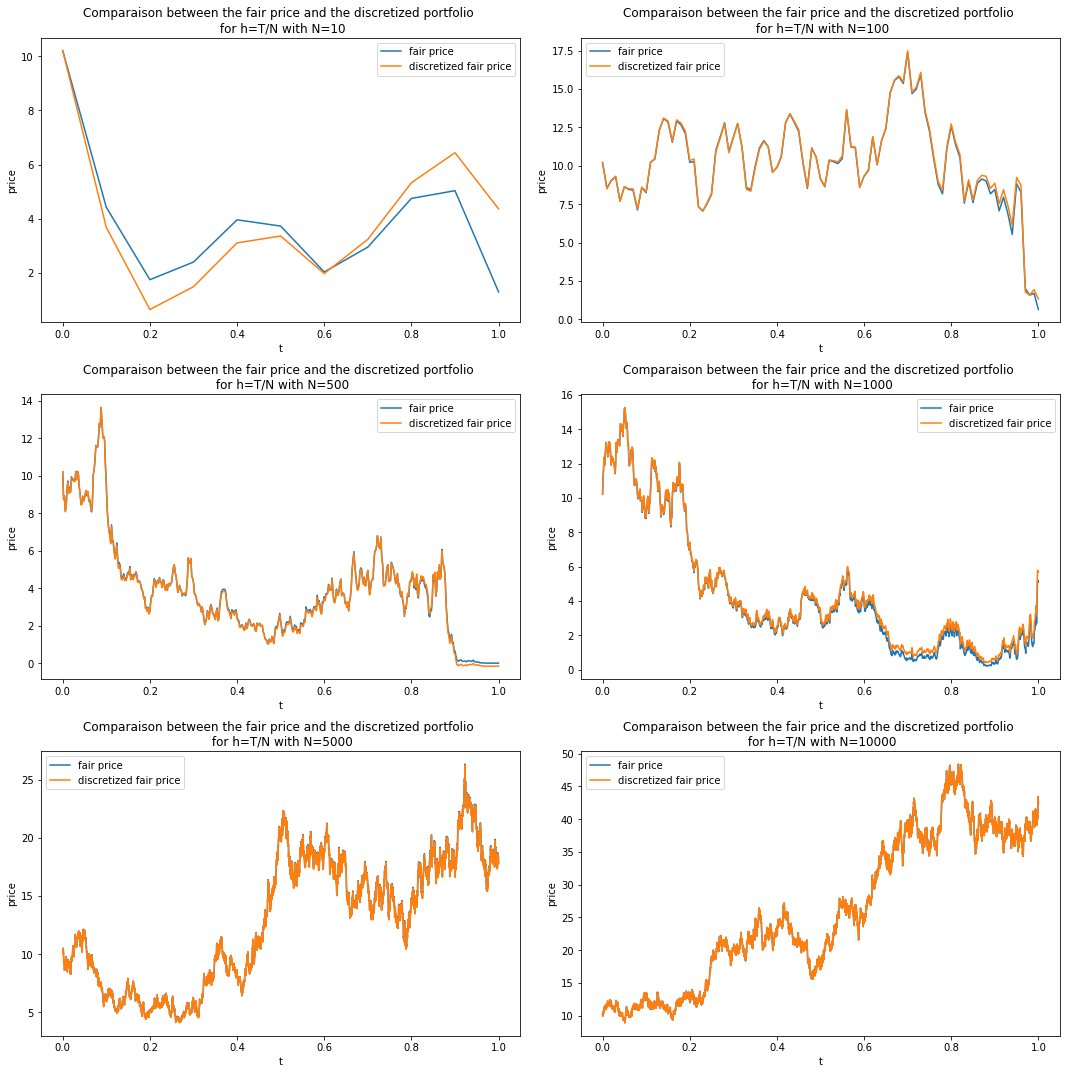

In [42]:
fig, axs = plt.subplots(3, 2,figsize=(15,15))

for i in range(6): 
    
    ax = axs[i//2, i%2]
    comp_payoff(K, S0, r, sigma, T, N[i], ax = ax)
    
fig.tight_layout(pad=1.0)

plt.show()

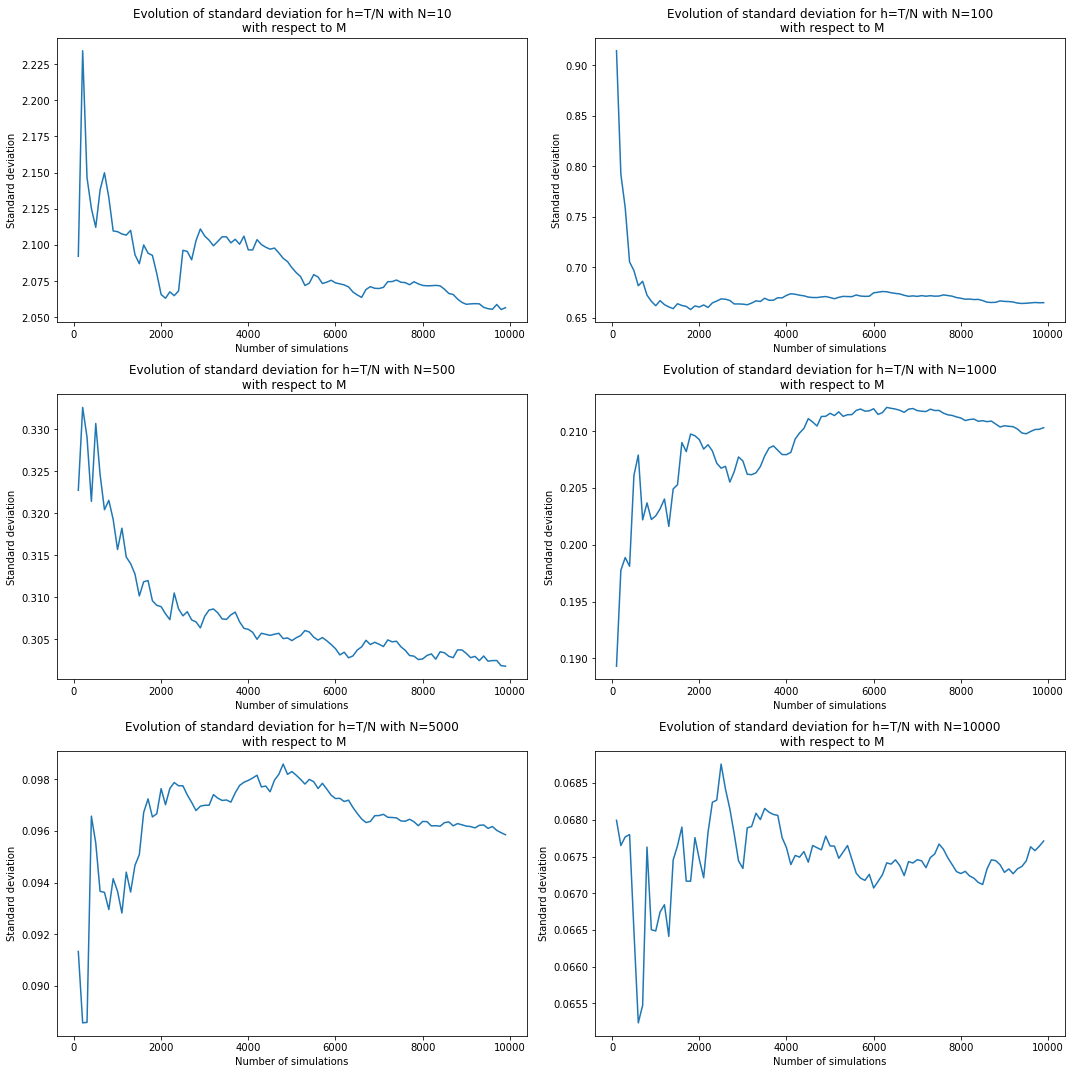

In [30]:
fig, axs = plt.subplots(3, 2,figsize=(15,15))

for i in range(6): 
    
    ax = axs[i//2, i%2]
    std(K, S0, r, sigma, T, N[i], M, ax = ax)
    
fig.tight_layout(pad=1.0)

plt.show()

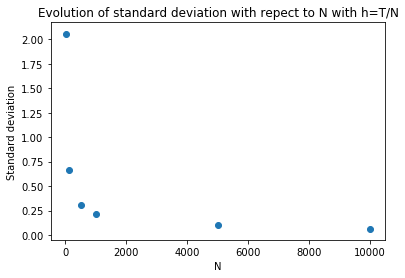

In [54]:
M = 4000
std_plot(K, S0, r, sigma, T, N, M)